## Example code for SDMs

In this code, you will get an idea of how SDMs are built and how to assess/ plot them visually
Also have a look at this [webpage] for more details on SDMs
Before you run the code, you need to keep the data structured in following folder structure:

 - /data/ (this is the root folder for all your data)
      - /data/input_rasters/ (this folder contains all your input .tif files)
          - /data/input_rasters/current/ (contains current input)
          - /data/input_rasters/projected/ (contains future input)
          - /data/input_rasters/presence-absence/ (contains 4 files; 
              only single file with presence-absence of species)
      - /data/output/ (this folder is used to store the generated output files)
          - /data/output/current/
          - /data/output/projected/
 - /code/ (this is the root folder for all your code/src files)
 

# code chunk to load all the libraries
# the missing libraries can be installed using "!pip install library_name" or "!conda install library_name"


In [ ]:
import os
from matplotlib import pyplot as plt
import rasterio
from rasterio.plot import show
import shapely
import geopandas as gpd
import shutil
import glob
from sklearn.model_selection import train_test_split 
from pyimpute import load_training_vector
from pyimpute import load_targets
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
from pyimpute import impute
from sklearn import model_selection as mod_sel
from sklearn.metrics import confusion_matrix as evaluate_conf

In [21]:
# os.chdir("Insert your root folder name where data and code are saved")
os.chdir("/Users/pranavkulkarni/SDM/Climate_Models_Arenaviruses/Samarth/old/Samarth")
os.getcwd() # to see if the directory has changed

'/Users/pranavkulkarni/SDM/Climate_Models_Arenaviruses/Samarth/old/Samarth'

In [22]:
# presence-absence data
pa = gpd.GeoDataFrame.from_file("./data/input_rasters/presence-absence/zyg.shp")


# input data
raster_features = sorted(glob.glob("./data/input_rasters/current/*.tif"))

# see structure of all inputs
print('number of raster features = ', len(raster_features), '; pa.shape = ', pa.shape)

number of raster features =  4 ; pa.shape =  (3095, 2)


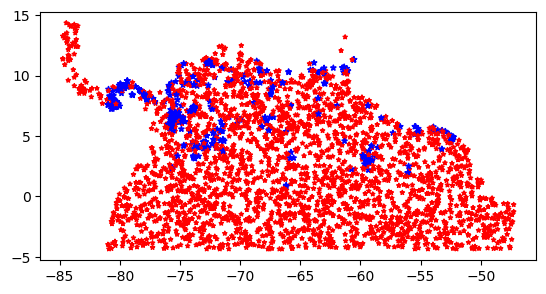

In [23]:
# plot presence absence and see shape
CLASS_palette = {1: 'blue', 0: 'red'}
CLASS_markersize = {1: 16, 0: 10}
map_gbif = pa.plot(marker = '*', color = pa.CLASS.map(CLASS_palette), markersize = pa.CLASS.map(CLASS_markersize))

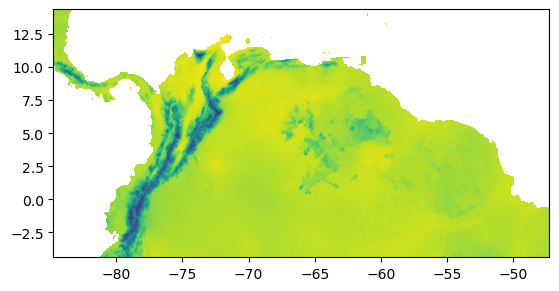

<Axes: >

In [28]:
# plot one or more raster features like this:
src = rasterio.open(raster_features[0])
show(src)

In [29]:
# Split in testing and training data with 75% 25% split

pa_train, pa_test = train_test_split(pa, test_size=0.25, stratify=pa['CLASS'])
print(pa_train.shape, pa_test.shape)

(2321, 2) (774, 2)


In [30]:
# load training data in the format that ML algorithms require
## following objects are needed: 
##    train_xs (all the raster variables with presence absence),
##    train_y (only presence absence)
##    target_xs (all raster variables without presence absence data)
##    raster_info (metadata required for output)

train_xs, train_y = load_training_vector(pa_train, raster_features, response_field = "CLASS")
## remove NA values by using averaged
imputer = SimpleImputer(missing_values = np.nan, strategy = "mean")
impute_train = imputer.fit(train_xs)
train_xs = impute_train.transform(train_xs)



target_xs, raster_info = load_targets(raster_features)
# remove NA values by replacing with 0
target_xs[np.isnan(target_xs)] = 0
print(train_xs.shape) # print the shape

(2321, 4)


In [31]:
# repeat the process for test data
test_xs, test_y = load_training_vector(pa_test, raster_features, response_field = "CLASS")
test_target_xs, test_raster_info = load_targets(raster_features)
impute_train = imputer.fit(test_xs)
test_xs = impute_train.transform(test_xs)

test_target_xs[np.isnan(test_target_xs)] = 0
print({'test_xs': test_xs.shape, 'test_target_xs': test_target_xs.shape})

{'test_xs': (774, 4), 'test_target_xs': (405000, 4)}


In [32]:
feature_names = ["Annual Mean Temperature (bclim_01)",
                "Annual Precipitation (bclim_12)",
                 "Cropland",
                "Urbanland"]

In [34]:
name = "RandomForest"
model = RandomForestClassifier()

In [35]:
k = 5 # for cross validation,  5 splits of training data
kf = mod_sel.KFold(n_splits = k) # run cross validation to generate the following performance values
accu_score = mod_sel.cross_val_score(model, train_xs, train_y, cv = kf, scoring = "accuracy")
print(name + "CV Accuracy: %0.2f (+/- %0.2f)"
                    % (accu_score.mean() * 100, accu_score.std() * 200))
accuracy_scores = mod_sel.cross_val_score(model, train_xs, train_y, cv=kf, scoring='roc_auc')
print(name + "CV AUC_ROC: %0.2f (+/- %0.2f)"
                    % (accuracy_scores.mean() * 100, accuracy_scores.std() * 200))

# for confusion matrix
model.fit(train_xs, train_y)
y_pred = model.predict(test_xs)
eval1 = evaluate_conf(test_y, y_pred)
print(eval1) # this will be a confusion matrix

## after running the model, generate the probability map using the following code

if os.path.exists("./data/output/current"): # this creates a folder if it is absent
    print('name folders exists')
else: 
    os.mkdir("./data/output/current")
impute(target_xs, model, raster_info,  
# this generates four files: 2 x probability maps, 1 x binary variable map same as the - 
#  - pa file, 1 x certainty map
        outdir = "./data/output/current/" + name + "-images",
        class_prob = True, 
        certainty = True)

RandomForestCV Accuracy: 90.56 (+/- 2.61)
RandomForestCV AUC_ROC: 91.64 (+/- 2.64)
[[599  20]
 [ 39 116]]
name folders exists


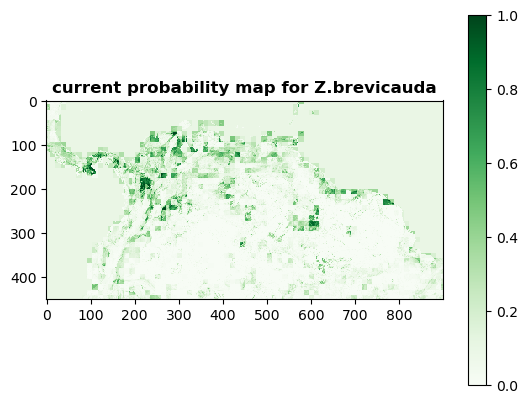

In [36]:
# to plot the imputed image
import matplotlib.pyplot as plt
def plotit(x, title, cmap = "Greens"):
    plt.imshow(x, cmap = cmap, interpolation = "nearest")
    plt.colorbar()
    plt.title(title, fontweight = "bold")


plotit(rasterio.open("./data/output/current/RandomForest-images/probability_1.0.tif").read(1), 
       "current probability map for Z.brevicauda", cmap = "Greens")

In [37]:
# now input future projected rasters for predicting the distribution of Z.brevicauda in future
future_rast = sorted(glob.glob("./data/input_rasters/projected/*.tif"))
future_rast

['./data/input_rasters/projected/bclim_01.tif',
 './data/input_rasters/projected/bclim_12.tif',
 './data/input_rasters/projected/lu_crop.tif',
 './data/input_rasters/projected/lu_urbn.tif']

In [38]:
# follow the same process for future rasters as we did for current
target_future, future_info = load_targets(future_rast)
target_future[np.isnan(target_future)] = 0

In [39]:
# use the future raster data to generate the image of future predictions

if os.path.exists("./data/output/projected"):
    print('name folders exists')
else: 
    os.mkdir("./data/output/projected")
impute(target_future, model, future_info,  # again should contain four images just like current images
        outdir = "./data/output/projected/" + name + "-images",
        class_prob = True, 
        certainty = True)

name folders exists


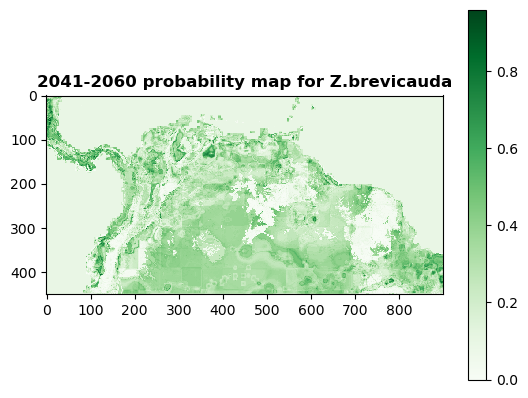

In [40]:
plotit(rasterio.open("./data/output/projected/RandomForest-images/probability_1.0.tif").read(1), 
       "2041-2060 probability map for Z.brevicauda", cmap = "Greens")

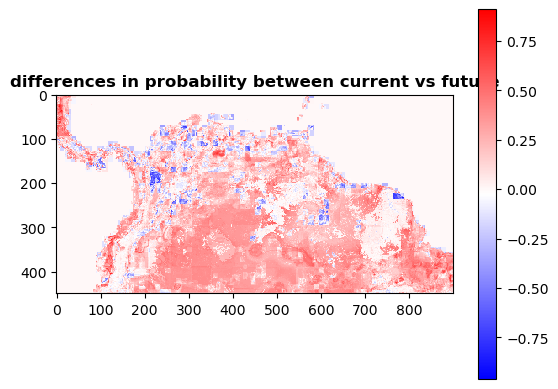

In [41]:
# see the difference in current and future probabilities by this method

current_map = rasterio.open("./data/output/current/RandomForest-images/probability_1.0.tif").read(1)
future_map = rasterio.open("./data/output/projected/RandomForest-images/probability_1.0.tif").read(1)

diff_map = (current_map - future_map)*-1

plotit(diff_map, 
       "differences in probability between current vs future", cmap = "bwr")